<a href="https://colab.research.google.com/github/Uiuran/engineering_exercises/blob/master/API_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API using Keras pre-processing and builders.

In this API, also, i provide namespace creator that exports dictionary with respective variable with name of namespace as keys and variable dictionaries, in the same mood as it is in Tensorflow 1.x. 

In [0]:
# Importing basic Python Modules to data container, computation and visualization 
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from io import BytesIO
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
from scipy import ndimage

# Importing Tensorflow, python API.
import tensorflow as tf

# Importing tensorflow.keras API, high level Python Tensorflow API with ex+ra functionalities
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator, array_to_img, img_to_array, load_img
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard as Board, EarlyStopping
from tensorflow.keras.preprocessing import image

from IPython.display import clear_output, Image, display, HTML
import PIL.Image
tf.keras.backend.clear_session()

In [0]:
#utils

def plot_image(img):

    fig = plt.figure()   
    fig.show()
    fig.canvas.draw() 
  
    ax = fig.add_subplot(111)  
    ax.imshow(np.int32(img) )
    fig.canvas.draw()
    return fig  

# A Namespace API for Keras Pre-processing


In [0]:
# keras pre-processing tools wrap-up
'''
brightness_range: Tuple or list of two floats. Range for picking a brightness shift value from.
shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
zoom_range: Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range: Float
'''

def start():
  global imagestyler_namespace
  imagestyler_namespace = NameSpace()

def start_keras_preprocessing():
  func_transf = AttrDict({
    "rotate_shift":rotate_shift,
   },
   "transforms")
  imagestyler_namespace.export(func_transf, "keras_transformations")


class AttrDict(dict):
  
  __getattr__ = dict.__getitem__
  __setattr__ = dict.__setitem__

  def __init__(self,*args):
    super(AttrDict, self).__init__()
    for a in args:
      if issubclass(a.__class__, str):
        self.__name__ = a
      elif issubclass(a.__class__, dict):
        self.update(a)
      elif issubclass(a.__class__, list) or issubclass(a.__class__, tuple):
        for item in range(len(a)):
          self[str(item)] = a[item]
      else:
        raise Exception("Data type not understood")

  def update(self, d):

    if issubclass(d.__class__, AttrDict):
      self[d.__name__] = d
    elif isinstance(d, dict):
      super(AttrDict, self).update(d)
    elif issubclass(a.__class__, list) or issubclass(a.__class__, tuple):
      for item in range(len(a)):
        self[str(item)] = a[item]
    else:
      raise Exception("object is not a dict or an AttrDict nor a iterable")

  def __str__(self):
    return self.__name__+"\n"+super(AttrDict, self).__str__()

class NameSpace:
  '''
   This class define namespaces inside the software general namespace imagestyler_namespace.
   Each namespace save its working structures in the attr vars. Each structure goes inside a collection in vars.
   
   TODO: future attr const of namespaces will hold numerical values to save models of algorithmically image processing, including dnns.
  '''
  def export(self, variable, namespace):
    if not hasattr(self, namespace):
      setattr(self, namespace, AttrDict({"vars":AttrDict({variable.__name__ : variable}, "variables")}, namespace))      
    else:
      if not hasattr(self[namespace], "vars"):        
        setattr(self[namespace], "vars", AttrDict({variable.__name__ : variable}, "variables"))        
      else:
        s=getattr(self, namespace)
        v=getattr(s, "vars")
        v[variable.__name__] = variable        

  @staticmethod
  def verify_namespace( namespace_name):
    if hasattr(imagestyler_namespace, namespace_name):
      return True
    else:
      return False

  def verify_collection(namespace, collection_name):
    if NameSpace.verify_namespace(namespace):
      s=getattr(imagestyler_namespace, namespace)      
      if hasattr(s["vars"], collection_name):
        return True
      else:
        return False
    else:
      raise Exception()

  @staticmethod
  def get_collection(namespace, collection_name):
    if NameSpace.verify_namespace(namespace):
      if NameSpace.verify_collection(namespace, collection_name):
        s = getattr(imagestyler_namespace, namespace)        
        v = getattr(s, "vars")
        return v[collection_name]
      else:
        raise Exception("Collection does not exist.")
    else:
      raise Exception("undefined Namespace")


# Keras preprocessing builder wrap-up

In [0]:
# keras pre-processing tools wrap-up
'''
brightness_range: Tuple or list of two floats. Range for picking a brightness shift value from.
shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
zoom_range: Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range: Float
'''
class PreprocessingError(Exception):

  def __init__(self, msg, info):
    self.msg=msg
    self.info

  def __str__(self):
    message = msg+" "
    for info in self.info:      
      message += info+" .\n"
    return message

#### Import from backend custom transforms


def rotate_shift(data,                     
                 **kwargs
):
  '''
  data: argment must be a DirectoryIterator that inherits from keras ImageDataGenerator.

  Keyword-args:
  rotation_const: float, the primary angle to rotate 'c'.
  shift: float.
  transforms_num: integer.
  '''
  for i in np.arange(1,kwargs["transforms_num"]):
    data.image_data_generator.height_shift_range=kwargs["shift"]
    data.image_data_generator.width_shift_range=kwargs["shift"]
    #data.image_data_generator.rescale=np.abs(np.sin(0.53*i))
    if i%2==0:
      data.image_data_generator.horizontal_flip=True
    else:
      data.image_data_generator.horizontal_flip=False
    if i%3==0:
      data.image_data_generator.vertical_flip=True
    else:
      data.image_data_generator.vertical_flip=False  
    if hasattr(kwargs["rotation_function"], '__call__' ):
      rotation=kwargs["rotation_function"](i,kwargs["rotation_const"])
      if len(rotation)==2:
        data.image_data_generator.rotation_range=int(kwargs["rotation_function"](i,kwargs["rotation_const"])[0]*kwargs["rotation_function"](i,kwargs["rotation_const"])[1])
      else:
        print("argment rotation_function must be a bi-variate function return two numbers, a rotation transform and a standart rotation.")
    else:
      print(" rotation_function must be a python callable giving a rotation angle.")

####

class Preprocessing(object):

  transforms_lookup = {
    "rotate_shift": rotate_shift,
  }
  info = { "keras_based" : lambda:\
    "rotation_function: callable returning float, e.g. lambda x,c: [x,c], the function that change the angle to rotate"
  }   

  data = None
  configure = None
  __name__ = None

  @staticmethod
  def new():
    return PreprocessingBuilder()

  def __call__(self, operation_name):    
    if operation_name=="rotate_shift":
      try:
        print(self.transforms_lookup)
        self.transforms_lookup[operation_name](self.data, **self.configure[operation_name])
      except:
        raise KeyError("{0} not found in look up transforms".format(operation_name))
    else:
        raise PreprocessingError("transformation not found.", operation_name)
    return self

  def next(self):
    return self.data.next()

  def next_data(self,**kwargs):
    if kwargs:
      batch = kwargs["batch"]
    else:
      batch=0
    return self.data.next()[0][batch]

  def next_classes(self, **kwargs):
    if kwargs:
      batch = kwargs["batch"]
    else:
      batch=0
    return self.data.next()[1][batch]

  def __str__():
    return info["keras_based"]()

  def __next__(self):
    return self.next()

  def __iter__(self):
    return self

# Better name to this class pls

class KerasImagePreprocessingBuilder:
  
  def load_data(self,                                                             
               initial_transform_name=None,
               dataloader_args=None,
               classes=[""],
               batch_size=1,
               target_size=(512,512),
               **kwargs):      

           
    if dataloader_args:
      keras_generator = ImageDataGenerator(**dataloader_args)
    else:
      keras_generator = ImageDataGenerator()
    self.batch_size=batch_size 
    self.add_all()    
    self.preprocess.data = keras_generator.flow_from_directory(self.directory,
                                       target_size=target_size,
                                       shuffle=False,
                                       classes=classes,
                                       batch_size=batch_size)
    
    if initial_transform_name:
      self.config(initial_transform_name, kwargs)
    else:
      print("Warning: initial transform not given, you must run CompVisionTransforms.config before transform an image.")

    self.preprocess.__name__ = "Keras Preprocess" 
    return self
    
  def add_all(self):
    collection = imagestyler_namespace.get_collection("keras_transformations", "transforms")
    for transformation in collection:
      if transformation == collection.__name__:
        pass
      else:
        self.preprocess.transforms_lookup[transformation] = collection[transformation]  

  def config(self,
             transform_name,
             **kwargs
  ):
    if not hasattr(self, "configure"):
      self.preprocess.configure={}
    if transform_name=="rotate_shift":
      for keys in kwargs.keys():        
        if keys == "shift":
          self.preprocess.configure["shift"] = kwargs["shift"]
        if keys == "rotation_function":
          self.preprocess.configure["rotation_function"] = kwargs["rotation_function"]
        if keys == "transforms_num":
          self.preprocess.configure["transforms_num"] = kwargs["transforms_num"]
        if keys == "rotate_const":
          self.preprocess.configure["rotate_const"] = kwargs["rotate_const"]

        if ("shift" in self.preprocess.configure) and ("transform_nums" in self.preprocess.configure) and ("rotation_function" in self.preprocess.configure) and ("rotate_const" in self.preprocess.configure):
          self.preprocess.configure = { transform_name:
            {
              "shift":self.preprocess.configure["shift"],
              "transforms_num":self.preprocess.configure["transform_num"],
              "rotation_function":self.preprocess.configure["rotation_function"],
              "rotation_const":self.preprocess.configure["rotation_const"]
            }
          }
        else:
          self.preprocess.configure = { transform_name:
            {
              "shift":1.2,
              "transforms_num":10,
              "rotation_function": lambda x,c: (x*(x-1),c),
              "rotation_const": 0.3
            }
          }

    elif transform_name=="kiss_your_ass":
      pass

    else:
      raise PreprocessingError("Configuration not found", [transform_name, self.preprocess.configure])
    return self

class PreprocessingBuilder(KerasImagePreprocessingBuilder):

  def __new__(cls, directory):

    obj = super().__new__(cls)    
    obj.directory = directory
    obj.preprocess = Preprocessing()  
    imagestyler_namespace.export( obj.preprocess, "preprocessing")     
    return obj

  def build(self):    
    return self.preprocess  



## Test of previous lib, builded in the inheritance of KerasPreprocessing of Preprocessing Builder

keras_transformations
{'vars': {'transforms': {'rotate_shift': <function rotate_shift at 0x7f861d4a9e18>, '__name__': 'transforms'}, '__name__': 'variables'}, '__name__': 'keras_transformations'}
Found 1 images belonging to 1 classes.
{'rotate_shift': <function rotate_shift at 0x7f861d4a9e18>, '__name__': 'transforms'}
{'rotate_shift': <function rotate_shift at 0x7f861d4a9e18>, '__name__': 'transforms'}
{'rotate_shift': <function rotate_shift at 0x7f861d4a9e18>, '__name__': 'transforms'}
{'rotate_shift': <function rotate_shift at 0x7f861d4a9e18>, '__name__': 'transforms'}


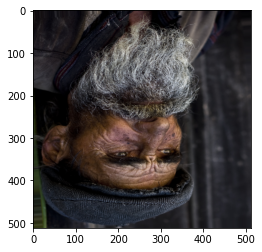

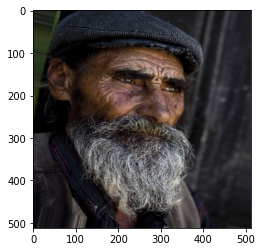

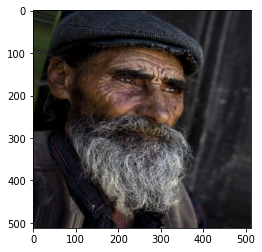

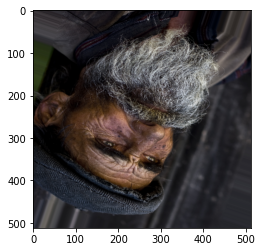

In [0]:
path = "/content/"
# Invoques namespace
start()
start_keras_preprocessing()
print(imagestyler_namespace.keras_transformations)
# Display preprocessing
data = PreprocessingBuilder(path)\
      .load_data()\
      .config("rotate_shift", shift=5, rotation_function=lambda x,c: (x**2.0,c), transforms_num=27, rotation_const=17.3)\
      .build()
       
for i in range(4):  
  data=data("rotate_shift")
  img=data.next_data()
  plot_image(img)
